# Analyse slip velocity particle
In this notebook I analyse the slip velocity (difference fluid velocity and particle velocity)   
to make an estimation for the Reynolds partilcle number ($Re_p = U_{slip} d / \nu $). As  
pointed out by Irina $Re_p$ might not be small and thus additional corrections to the Stokes  
drag force in the form of $\nu\rightarrow\nu_{eff}=\nu(1+f(RE_p))$ should be added.       
To investigate this we measure the slip velocity in simulations with MR advection using:  
1. stokes drag
2. drag with  $fRe_p$ dependend drag  
And we do this for the slow manifold and full MR equation. We also investigate:   
1. variability $Re_p$
2. spin up time simulation (how mcuh time is needed before  slip velocity / $Re_p$ stabilizes)
32. effect of different timesteps


In [48]:
# import needed packages
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import cartopy.crs as ccrs #for plotting on map
import cartopy as cart
from decimal import Decimal


from datetime import datetime, timedelta
from analysis_functions import trajectory_length,  make_PDF, Haversine, running_mean
import sys
sys.path.append("/nethome/4291387/Maxey_Riley_advection/Maxey_Riley_advection/simulations")
from helper import create_filelist

plt.style.use('../python_style_Meike.mplstyle')

Rearth = 6371 * 10**3 # in m,
deg2rad = np.pi / 180.
color_array = np.array(['c','orange','purple','black'])
marker_array = np.array(['s','o','>','p'])
line_array = np.array(['-','--','-.',':'])
markerline_array = np.array(['-s','--o','-.>',':p'])
sec_in_hours= 3600



In [2]:
# define functions
def Re_slip(Uslip, L, nu):
    """
    Calculates Reynolds number based 
    on slip velocity particle
    L is lengthscale particle
    Uslip slip velocity (differnece particle and fluid velocity)
    nu is kinematic velocity water
    """
    return Uslip*L / nu

# needed functions: 
def calc_tidal_av(coordinates, window):
    cs = coordinates.cumsum(dim='obs',skipna=False)
    mean = (cs-cs.roll(obs=window))/float(window)#(cs[:,window:]-cs[:,:-window])#/float(window)
    return mean

L = 0.2 #m
rho_water = 1027 # kg/m3 https://www.engineeringtoolbox.com/sea-water-properties-d_840.html (at 10 deg)
dynamic_viscosity_water = 1.41 * 10**(-3) # kg/(ms) https://www.engineeringtoolbox.com/sea-water-properties-d_840.html (at 10 deg)
kinematic_viscosity_water = dynamic_viscosity_water / rho_water

## Settings
First we evaluate short simulations 
location: NWES  
dt_write = 5 min  
dt = 1 min  
runtime = 24 h   
startime = 2 sep 2023 0:30  
3

In [3]:
particle_types = ['inertial','inertial_SM','inertial_drag_REp','inertial_SM_drag_REp']
legendnames=['MR Stokes drag','MRSM Stokes drag','MR Re$_p$ drag','MRSM Re$_p$ drag']

file_base = ('/storage/shared/oceanparcels/output_data/'
             'data_Meike/MR_advection/NWES/{particle_type}/'
            '{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                 '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_B{B:04d}_tau{tau:04d}_{land_handling}_cor_{cor_on}_slip_velocity.zarr')

data_2days ={}

#settings
runtime =  timedelta(days=1)# timedelta(days=10)
loc = 'NWES'
B = 0.68
tau = 2759.97
coriolis = True
land_handling = 'anti_beaching'
starttime = datetime(2023, 9, 2, 0, 0, 0, 0)
endtime = starttime + runtime

chunck_time = 100
nparticles = 88347

for particle_type in particle_types: 
    file = file_base.format(loc=loc,
                           particle_type = particle_type,
                                                            y_s=starttime.year,
                                                            m_s=starttime.month,
                                                            d_s=starttime.day,
                                                            y_e=endtime.year,
                                                            m_e=endtime.month,
                                                            d_e=endtime.day,
                                                            B = int(B * 1000), 
                                                            tau = int(tau ),
                                                            land_handling = land_handling, 
                                                            cor_on = coriolis)
    ds = xr.open_dataset(file,
                                    engine='zarr',
                                    chunks={'trajectory':nparticles, 'obs':chunck_time},
                                    drop_variables=['B','tau','z'],
                                    decode_times=False) #,decode_cf=False)
    Uslip = np.sqrt(ds.uf**2 + ds.vf**2) 
    ds = ds.assign(Uslip = Uslip)
    data_2days[particle_type]=ds
    

In [4]:
ds_compare = xr.open_dataset('/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/NWES/inertial_drag_REp/NWES_start2023_09_02_end2023_09_03_RK4_B0680_tau2759_anti_beaching_cor_True_slip_velocity_v2.zarr',                                    engine='zarr',
                                    chunks={'trajectory':nparticles, 'obs':chunck_time},
                                    drop_variables=['B','tau','z'],
                                    decode_times=False) #,decode_cf=False)
Uslip = np.sqrt(ds_compare.uf **2 + ds_compare.vf**2) 
ds_compare = ds_compare.assign(Uslip = Uslip)

In [5]:
#performed some short simulations where I load in all the data 
# so I can use central time derivatives and larger delta_t for
#  caluclating the time derivatives but probalby do not want to go
#  into this rabbithole (as this would mean rewriting everything in 
# the end)

particle_types = ['inertial','inertial_SM','inertial_drag_REp','inertial_SM_drag_REp']

file_base = ('/storage/shared/oceanparcels/output_data/'
             'data_Meike/MR_advection/NWES/{particle_type}/'
            '{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                 '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_B{B:04d}_tau{tau:04d}_{land_handling}_cor_{cor_on}_slip_velocity_central_time_derivative.zarr')

data_ctd ={}

#settings
runtime =  timedelta(days=1)# timedelta(days=10)
loc = 'NWES'
B = 0.68
tau = 2759.97
coriolis = True
land_handling = 'anti_beaching'
starttime = datetime(2023, 9, 2, 0, 0, 0, 0)
endtime = starttime + runtime

chunck_time = 100
nparticles = 88347

for particle_type in particle_types: 
    file = file_base.format(loc=loc,
                           particle_type = particle_type,
                                                            y_s=starttime.year,
                                                            m_s=starttime.month,
                                                            d_s=starttime.day,
                                                            y_e=endtime.year,
                                                            m_e=endtime.month,
                                                            d_e=endtime.day,
                                                            B = int(B * 1000), 
                                                            tau = int(tau ),
                                                            land_handling = land_handling, 
                                                            cor_on = coriolis)
    ds = xr.open_dataset(file,
                                    engine='zarr',
                                    chunks={'trajectory':nparticles, 'obs':chunck_time},
                                    drop_variables=['B','tau','z'],
                                    decode_times=False) #,decode_cf=False)
    Uslip = np.sqrt(ds.uf**2 + ds.vf**2) 
    ds = ds.assign(Uslip = Uslip)
    data_ctd[particle_type]=ds
    

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


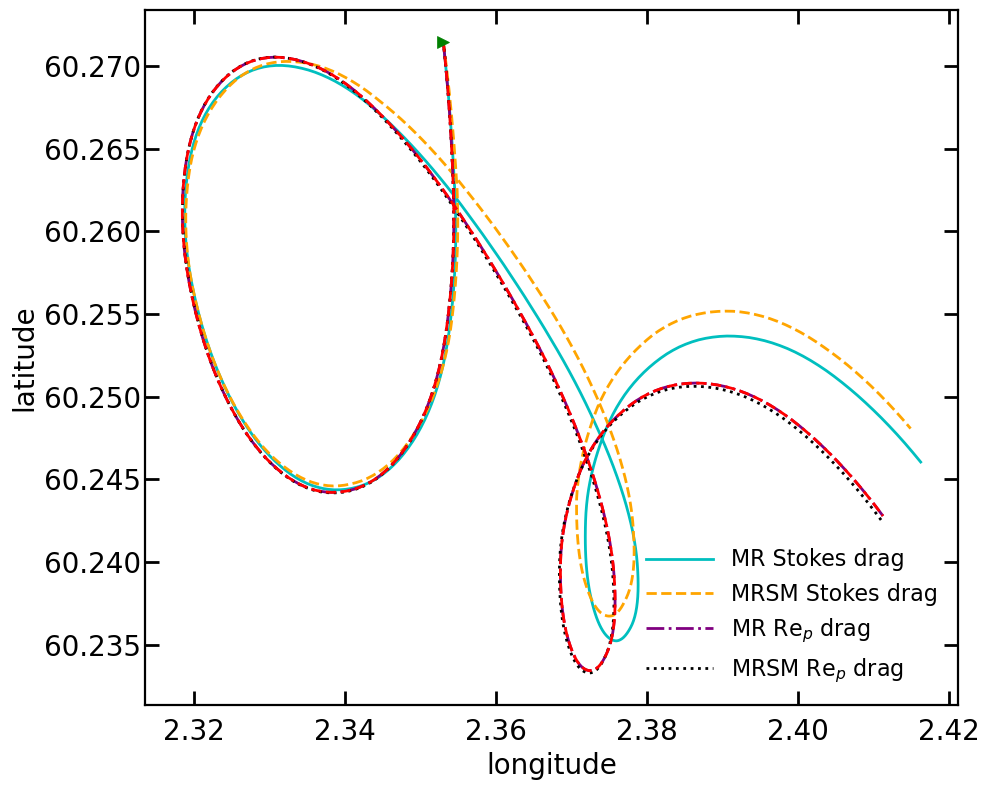

In [9]:
#compare trajectorties
id = 1# np.random.randint(nparticles,size=1)[0]

fig,ax = plt.subplots()#subplot_kw={'projection':ccrs.PlateCarree()})
# ax.coastlines()
# ax.add_feature(cart.feature.LAND, facecolor='lightgrey')
for particle_type,color, line in zip(particle_types,color_array, line_array):
    ax.plot(data_2days[particle_type].lon[id].values,data_2days[particle_type].lat[id].values,line,color=color)

ax.plot(ds_compare.lon[id].values,ds_compare.lat[id].values,'--',color='red')

ax.plot(data_2days[particle_type].lon[id,0],data_2days[particle_type].lat[id,0],'>',color='green')
ax.legend(legendnames,fontsize=16,loc=4)
# for particle_type,color in zip(particle_types,color_array):
#     ax.axvline(mean_Rep[particle_type],color=color,zorder=-5)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
fig.tight_layout()
fig.savefig(f'../figures/drag_force/trajecory_id{id:05d}_Rep_2days.pdf')



/storage/home/4291387/parcels_env/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: overflow encountered in square
  return func(*(_execute_task(a, cache) for a in args))
/storage/home/4291387/parcels_env/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: overflow encountered in add
  return func(*(_execute_task(a, cache) for a in args))
/storage/home/4291387/parcels_env/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: overflow encountered in square
  return func(*(_execute_task(a, cache) for a in args))
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


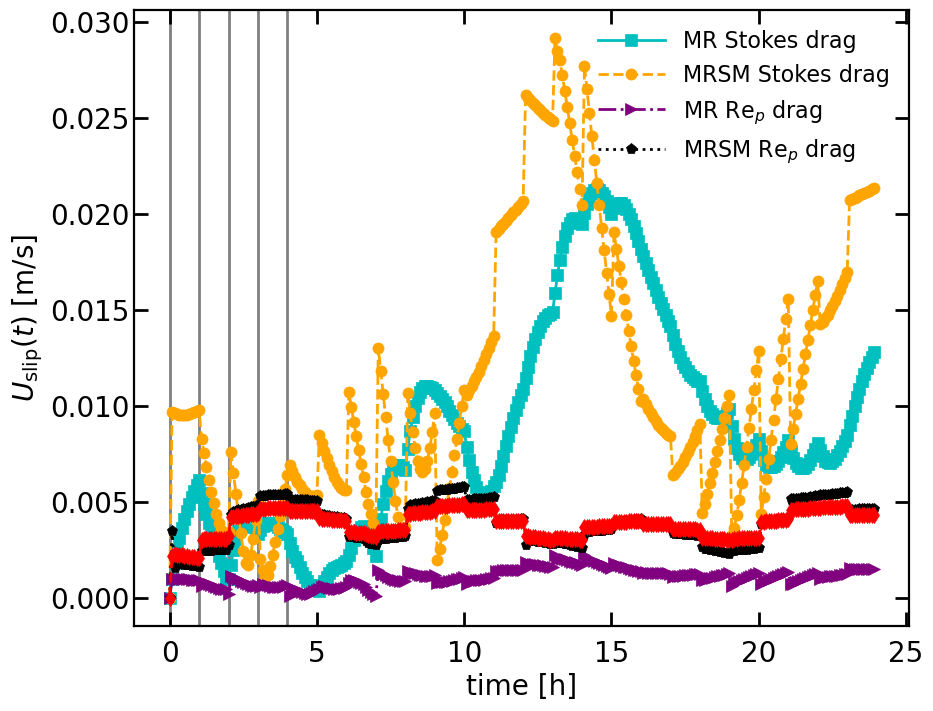

In [6]:
# stokes drag analysis
id = 1#np.random.randint(nparticles,size=1)[0]
fig, ax=plt.subplots()
legend=[]
for particle_type,marker,line, color in zip(particle_types,markerline_array,line_array,color_array): 
    # ax.plot((data_2days[particle_type].time[id,0:]-data_2days[particle_type].time[id,0])/sec_in_hours,data_2days[particle_type].Uslip[id]/data_2days[particle_type].Uslip[id].mean(dim='obs',skipna=True),marker,color=color)
    ax.plot((data_2days[particle_type].time[id,0:]-data_2days[particle_type].time[id,0])/sec_in_hours,data_2days[particle_type].Uslip[id],marker,color=color)
    # ax.plot((data_2days[particle_type].time[id,0:]-data_2days[particle_type].time[id,0])/sec_in_hours,data_2days[particle_type].Uslip[id],marker,color=color)
    # ax.plot((data_ctd[particle_type].time[id,0:]-data_ctd[particle_type].time[id,0])/sec_in_hours,data_ctd[particle_type].Uslip[id]/data_2days[particle_type].Uslip[id].mean(dim='obs',skipna=True),line,color=color)      
    # legend.append(particle_type)
    # legend.append(particle_type+'ctd')
# ax.set_yscale('log')
# ax.set_ylim(-0.001,0.001)
# ax.set_xlim(0,5)
# ax.set_ylim(-0.01,1.5)
ax.plot((ds_compare.time[id,0:]-ds_compare.time[id,0])/sec_in_hours,ds_compare.Uslip[id],'--d',color='red')
ax.legend(legendnames,fontsize=16)#loc=(1,0.3))
ax.set_xlabel('time [h]')
# ax.set_ylabel('$U_{\\mathrm{slip}}(t)$/$\\langle U_slip \\rangle$')
ax.set_ylabel('$U_{\\mathrm{slip}}(t)$ [m/s]')
for x in range(0,5,1):
    ax.axvline(x,color='grey',zorder=-5)

# fig.tight_layout()
# fig.savefig(f'../figures/drag_force/Uslip_id{id:05d}_Rep_2days.pdf')

/storage/home/4291387/parcels_env/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: overflow encountered in square
  return func(*(_execute_task(a, cache) for a in args))


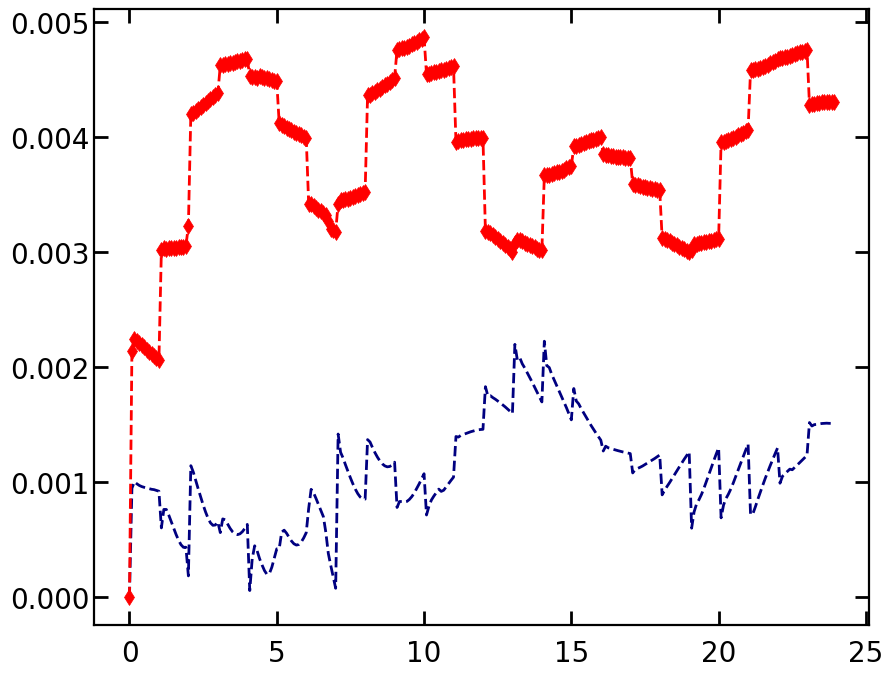

In [8]:
fig, ax = plt.subplots()
particle_type = 'inertial_drag_REp'
ax.plot((data_2days[particle_type].time[id,0:]-data_2days[particle_type].time[id,0])/sec_in_hours,data_2days[particle_type].Uslip[id],'--',color='navy')
ax.plot((ds_compare.time[id,0:]-ds_compare.time[id,0])/sec_in_hours,ds_compare.Uslip[id],'--d',color='red')

In [6]:
# make PDF and CDF for reynoldsnumber
mean_Rep={}
bins_Rep={}
pdfs_Rep={}
cdfs_Rep={}
for particle_type in particle_types:

    Re_particle = Re_slip(data_2days[particle_type].Uslip[:,12:],L, kinematic_viscosity_water)
    # mean_Rep[particle_type] = Re_particle.mean(dim=None, skipna=True).values
    array = Re_particle.values.flatten()
    array=array[~np.isnan(array)]
    
    array = array[array<100000]
    mean_Rep[particle_type]=np.mean(array)
    
    bins,pdf = make_PDF(array,nbins = 5000, norm = True)#,min=0,max=750000)
    dx=bins[1]-bins[0]
    cdf = np.cumsum(pdf*dx)
    bins_Rep[particle_type]=bins
    pdfs_Rep[particle_type]=pdf
    cdfs_Rep[particle_type]=cdf

/storage/home/4291387/parcels_env/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: overflow encountered in square
  return func(*(_execute_task(a, cache) for a in args))
/storage/home/4291387/parcels_env/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: overflow encountered in square
  return func(*(_execute_task(a, cache) for a in args))
/storage/home/4291387/parcels_env/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: overflow encountered in add
  return func(*(_execute_task(a, cache) for a in args))
/storage/home/4291387/parcels_env/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: overflow encountered in square
  return func(*(_execute_task(a, cache) for a in args))
/storage/home/4291387/parcels_env/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: overflow encountered in add
  return func(*(_execute_task(a, cache) for a in args))
/storage/home/4291387/parcels_env/lib/python3.12/site-packages/dask/core.py:127: Runti

/storage/home/4291387/parcels_env/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: overflow encountered in add
  return func(*(_execute_task(a, cache) for a in args))


5180.9995
5780.707
238.35759
946.6263


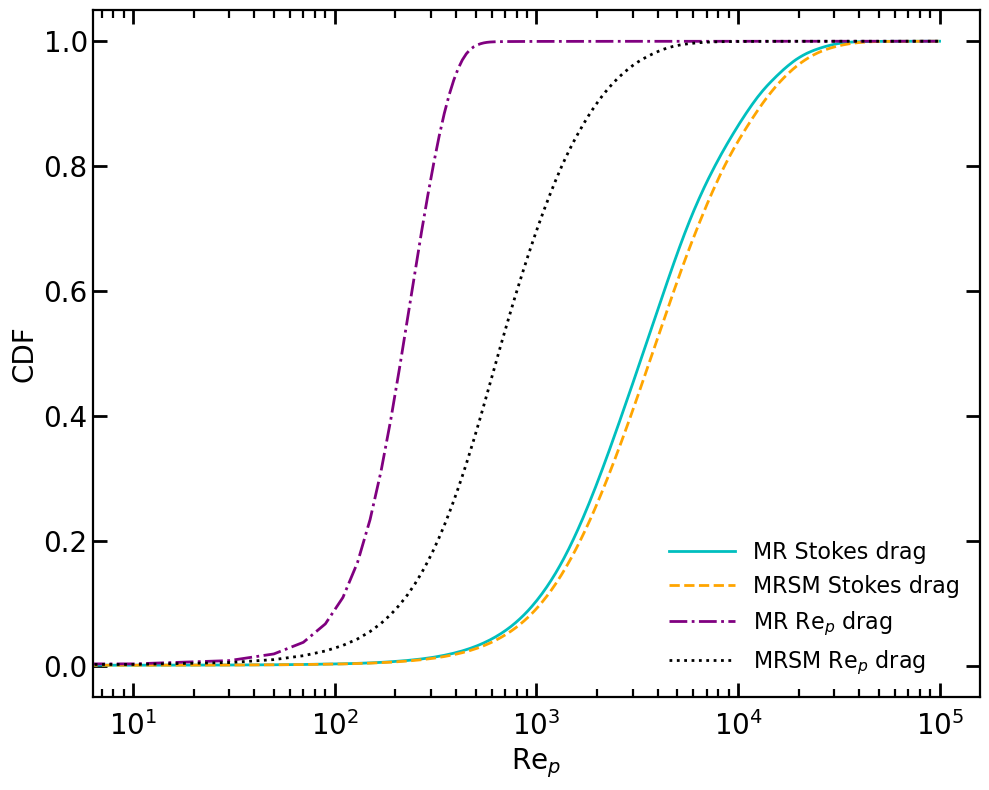

In [7]:
fig, ax = plt.subplots()

for particle_type, marker, color in zip(particle_types,line_array,color_array):
    print(   mean_Rep[particle_type])
    ax.plot(bins_Rep[particle_type],cdfs_Rep[particle_type],marker,color=color)
ax.set_xscale('log')
ax.legend(legendnames,fontsize=16,loc=4)
# for particle_type,color in zip(particle_types,color_array):
#     ax.axvline(mean_Rep[particle_type],color=color,zorder=-5)
ax.set_xlabel('Re$_p$')
ax.set_ylabel('CDF')
fig.tight_layout()
fig.savefig('../figures/drag_force/CDF_Rep_2days.pdf')


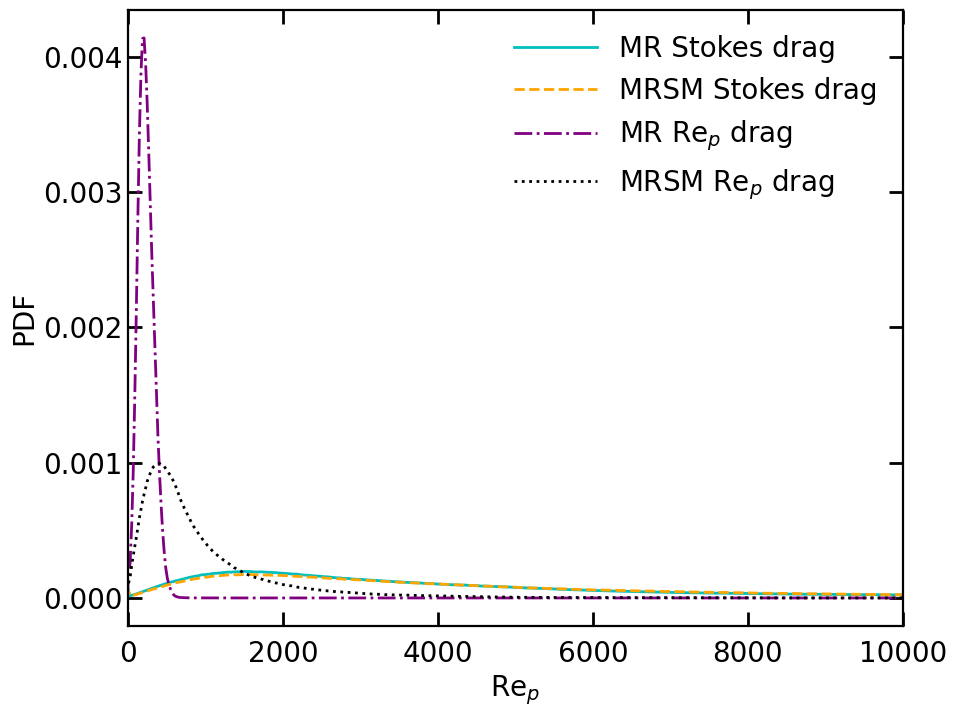

In [110]:
fig, ax = plt.subplots()
for particle_type, marker, color in zip(particle_types,line_array,color_array):

    ax.plot(bins_Rep[particle_type],pdfs_Rep[particle_type],marker,color=color)
ax.set_xlim(0,10000)
ax.set_xlabel('Re$_p$')
ax.set_ylabel('PDF')
ax.legend(legendnames)#,loc=(1,0.3))

# montly data
now do the same calculation for montly data and compare pdfs/cdfs

In [8]:
particle_types = ['inertial','inertial_SM','inertial_drag_REp','inertial_SM_drag_REp']
legendnames=['MR Stokes drag','MRSM Stokes drag','MR Re$_p$ drag','MRSM Re$_p$ drag']

file_base = ('/storage/shared/oceanparcels/output_data/'
             'data_Meike/MR_advection/NWES/{particle_type}/'
            '{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                 '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_B{B:04d}_tau{tau:04d}_{land_handling}_cor_{cor_on}_slip_velocity.zarr')

data_month ={}

#settings
runtime =  timedelta(days=30)# timedelta(days=10)
loc = 'NWES'
B = 0.68
tau = 2759.97
coriolis = True
land_handling = 'anti_beaching'
starttime = datetime(2023, 9, 2, 0, 0, 0, 0)
endtime = starttime + runtime

chunck_time = 100
nparticles = 88347

for particle_type in particle_types: 
    file = file_base.format(loc=loc,
                           particle_type = particle_type,
                                                            y_s=starttime.year,
                                                            m_s=starttime.month,
                                                            d_s=starttime.day,
                                                            y_e=endtime.year,
                                                            m_e=endtime.month,
                                                            d_e=endtime.day,
                                                            B = int(B * 1000), 
                                                            tau = int(tau ),
                                                            land_handling = land_handling, 
                                                            cor_on = coriolis)
    ds = xr.open_dataset(file,
                                    engine='zarr',
                                    chunks={'trajectory':nparticles, 'obs':chunck_time},
                                    drop_variables=['B','tau','z'],
                                    decode_times=False) #,decode_cf=False)
    Uslip = np.sqrt(ds.uf**2 + ds.vf**2) 
    ds = ds.assign(Uslip = Uslip)
    data_month[particle_type]=ds
    

Text(0, 0.5, '$U_{\\mathrm{slip}}(t)$ [m/s]')

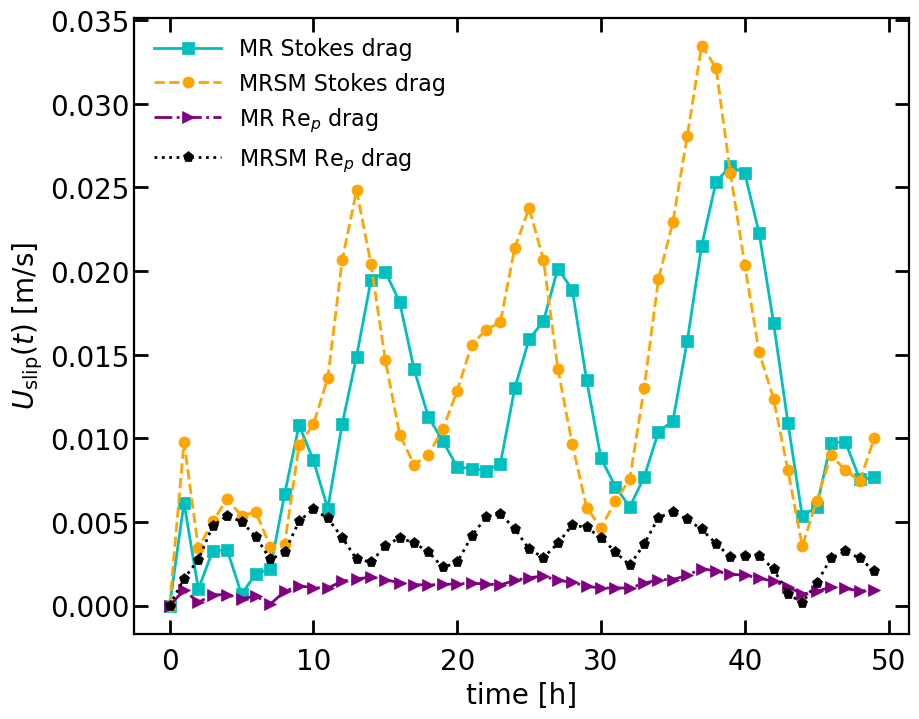

In [36]:
# stokes drag analysis
id = 1#np.random.randint(nparticles,size=1)[0]
fig, ax=plt.subplots()
legend=[]
for particle_type,marker,line, color in zip(particle_types,markerline_array,line_array,color_array): 
    # ax.plot((data_month[particle_type].time[id,0:50]-data_month[particle_type].time[id,0])/sec_in_hours,data_month[particle_type].Uslip[id,0:50]/data_month[particle_type].Uslip[id,0:50].mean(dim='obs',skipna=True),marker,color=color)
    ax.plot((data_month[particle_type].time[id,0:50]-data_month[particle_type].time[id,0])/sec_in_hours,data_month[particle_type].Uslip[id,0:50],marker,color=color)
    # ax.plot((data_2days[particle_type].time[id,0:]-data_2days[particle_type].time[id,0])/sec_in_hours,data_2days[particle_type].Uslip[id],marker,color=color)
    # ax.plot((data_ctd[particle_type].time[id,0:]-data_ctd[particle_type].time[id,0])/sec_in_hours,data_ctd[particle_type].Uslip[id]/data_2days[particle_type].Uslip[id].mean(dim='obs',skipna=True),line,color=color)      
    # legend.append(particle_type)
    # legend.append(particle_type+'ctd')
# ax.set_yscale('log')
# ax.set_ylim(-0.001,0.001)
# ax.set_xlim(0,5)
# ax.set_ylim(-0.01,1.5)
ax.legend(legendnames,fontsize=16)#loc=(1,0.3))
ax.set_xlabel('time [h]')
# ax.set_ylabel('$U_{\\mathrm{slip}}(t)$/$\\langle U_slip \\rangle$')
ax.set_ylabel('$U_{\\mathrm{slip}}(t)$ [m/s]')


# fig.tight_layout()
# fig.savefig(f'../figures/drag_force/Uslip_id{id:05d}_Rep_month.pdf')

In [18]:
# make PDF and CDF for reynoldsnumber
mean_Rep_month={}
bins_Rep_month={}
pdfs_Rep_month={}
cdfs_Rep_month={}
for particle_type in particle_types:

    Re_particle = Re_slip(data_month[particle_type].Uslip[:,1:],L, kinematic_viscosity_water)
    # mean_Rep[particle_type] = Re_particle.mean(dim=None, skipna=True).values
    array = Re_particle.values.flatten()
    array=array[~np.isnan(array)]
    
    array = array[array<100000]
    mean_Rep_month[particle_type]=np.mean(array)
    
    bins,pdf = make_PDF(array,nbins = 5000, norm = True)#,min=0,max=750000)
    dx=bins[1]-bins[0]
    cdf = np.cumsum(pdf*dx)
    bins_Rep_month[particle_type]=bins
    pdfs_Rep_month[particle_type]=pdf
    cdfs_Rep_month[particle_type]=cdf

5180.9995
5780.707
238.35759
946.6263


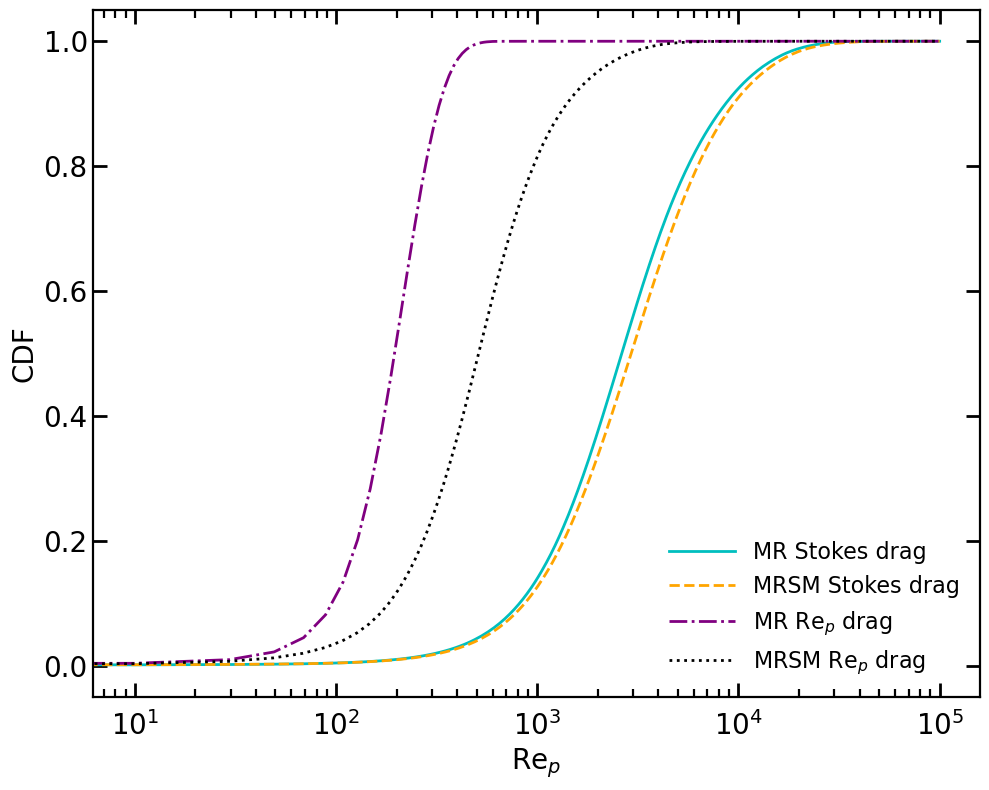

In [15]:
fig, ax = plt.subplots()

for particle_type, marker, color in zip(particle_types,line_array,color_array):
    print(   mean_Rep[particle_type])
    ax.plot(bins_Rep_month[particle_type],cdfs_Rep_month[particle_type],marker,color=color)
ax.set_xscale('log')
ax.set_xscale('log')
ax.legend(legendnames,fontsize=16,loc=4)
# for particle_type,color in zip(particle_types,color_array):
#     ax.axvline(mean_Rep[particle_type],color=color,zorder=-5)
ax.set_xlabel('Re$_p$')
ax.set_ylabel('CDF')
fig.tight_layout()
fig.savefig('../figures/drag_force/CDF_Rep_2days.pdf')


Text(0, 0.5, 'CDF')

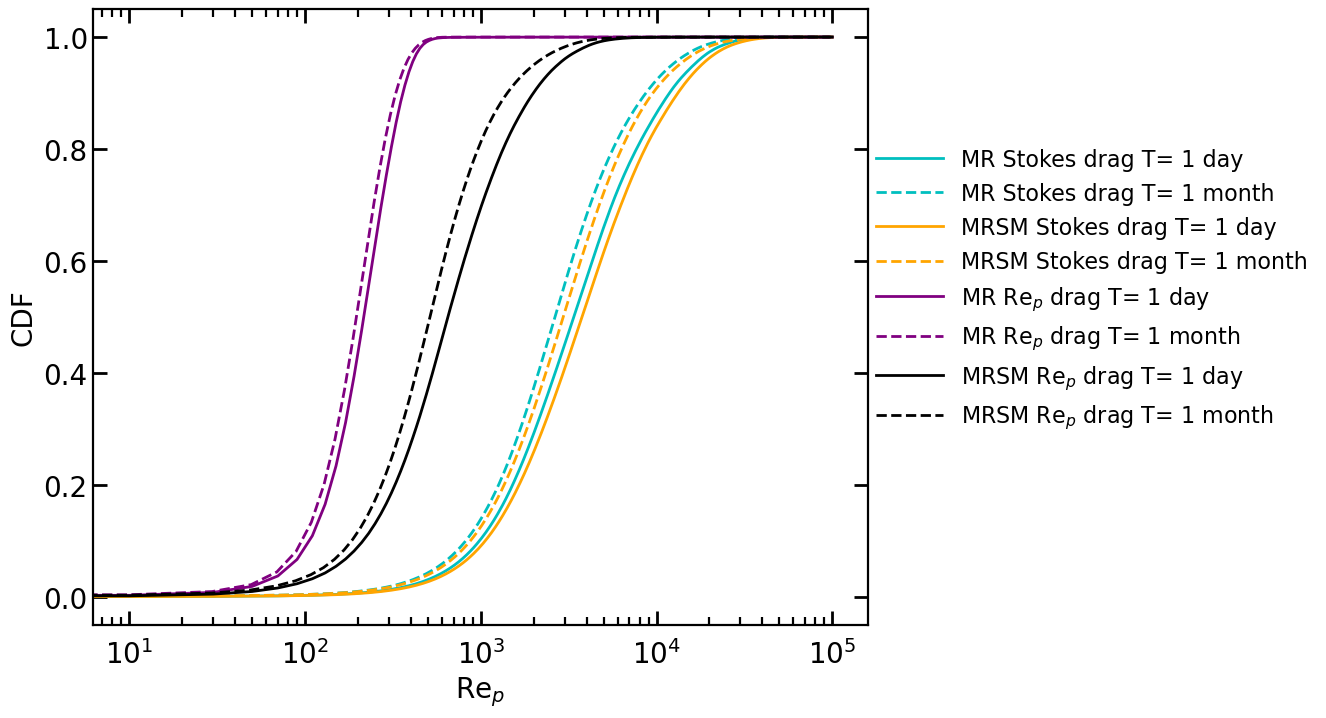

In [24]:
fig, ax = plt.subplots()
legend=[]
for particle_type, color, l in zip(particle_types, color_array, legendnames):
    legend.append(l+' T= 1 day')
    legend.append(l+' T= 1 month')
    ax.plot(bins_Rep[particle_type],cdfs_Rep[particle_type],'-',color=color)
    ax.plot(bins_Rep_month[particle_type],cdfs_Rep_month[particle_type],'--',color=color)
ax.set_xscale('log')

ax.legend(legend,fontsize=16,loc=(1,0.3))
# for particle_type,color in zip(particle_types,color_array):
#     ax.axvline(mean_Rep[particle_type],color=color,zorder=-5)
ax.set_xlabel('Re$_p$')
ax.set_ylabel('CDF')
#conclusion, a bit lower reynolds number when averaged over everything

5180.9995
3971.9946
5780.707
4404.884
238.35759
215.83331
946.6263
717.56354


Text(0, 0.5, 'PDF')

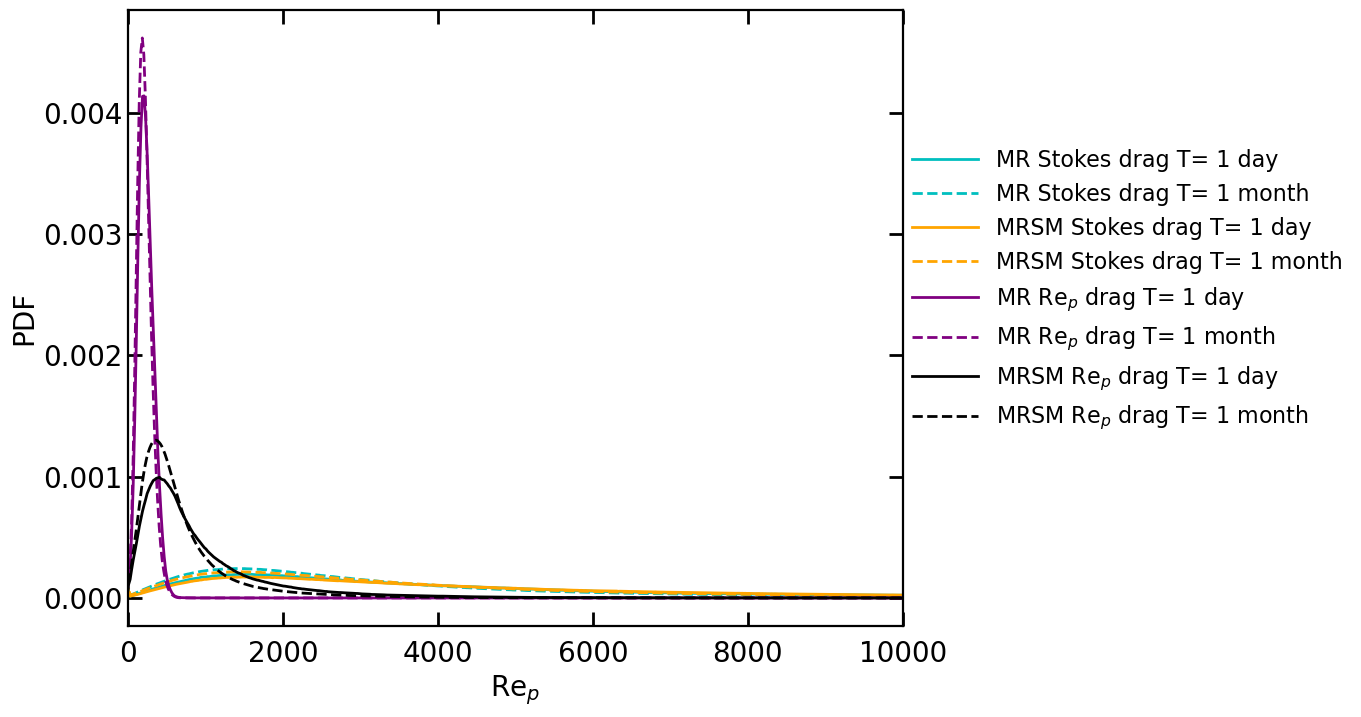

In [27]:
fig, ax = plt.subplots()
legend=[]
for particle_type, color, l in zip(particle_types, color_array, legendnames):
    legend.append(l+' T= 1 day')
    legend.append(l+' T= 1 month')
    print(   mean_Rep[particle_type])
    print(   mean_Rep_month[particle_type])
    ax.plot(bins_Rep[particle_type],pdfs_Rep[particle_type],'-',color=color)
    ax.plot(bins_Rep_month[particle_type],pdfs_Rep_month[particle_type],'--',color=color)


ax.legend(legend,fontsize=16,loc=(1,0.3))
# for particle_type,color in zip(particle_types,color_array):
#     ax.axvline(mean_Rep[particle_type],color=color,zorder=-5)
ax.set_xlim(0,10000)
ax.set_xlabel('Re$_p$')
ax.set_ylabel('PDF')

# constant reynolds number
now use constant reynolds number of REp = 300, 500, 1000, 5000

In [ ]:


Replist = np.array([300,500, 1000, 5000])


file_base = ('/storage/shared/oceanparcels/output_data/'
             'data_Meike/MR_advection/NWES/{particle_type}/'
            '{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                 '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_B{B:04d}_tau{tau:04d}_{land_handling}_cor_{cor_on}_Rep_{Rep:04d}_slip_velocity.zarr')
#settings
runtime =  timedelta(days=1)# timedelta(days=10)
loc = 'NWES'
B = 0.68
tau = 2759.97
coriolis = True
land_handling = 'anti_beaching'
starttime = datetime(2023, 9, 2, 0, 0, 0, 0)
endtime = starttime + runtime
particle_type = 'inertial_Rep_constant'

chunck_time = 100
nparticles = 88347
data_Rep_constant_24h = {}
for Rep in Replist: 
    file = file_base.format(loc=loc,
                           particle_type = particle_type,
                                                            y_s=starttime.year,
                                                            m_s=starttime.month,
                                                            d_s=starttime.day,
                                                            y_e=endtime.year,
                                                            m_e=endtime.month,
                                                            d_e=endtime.day,
                                                            B = int(B * 1000), 
                                                            tau = int(tau ),
                                                            land_handling = land_handling, 
                                                            cor_on = coriolis,
                                                            Rep = Rep )
    ds = xr.open_dataset(file,
                                    engine='zarr',
                                    chunks={'trajectory':nparticles, 'obs':chunck_time},
                                    drop_variables=['B','tau','z'],
                                    decode_times=False) #,decode_cf=False)
    Uslip = np.sqrt(ds.uf**2 + ds.vf**2) 
    ds = ds.assign(Uslip = Uslip)
    data_Rep_constant_24h[Rep]=ds

FileNotFoundError: No such file or directory: '/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/NWES/inertial_Rep_constant/NWES_start2023_09_02_end2023_09_03_RK4_B0680_tau2759_anti_beaching_cor_True_Rep_0000_slip_velocity.zarr'

KeyError: 0

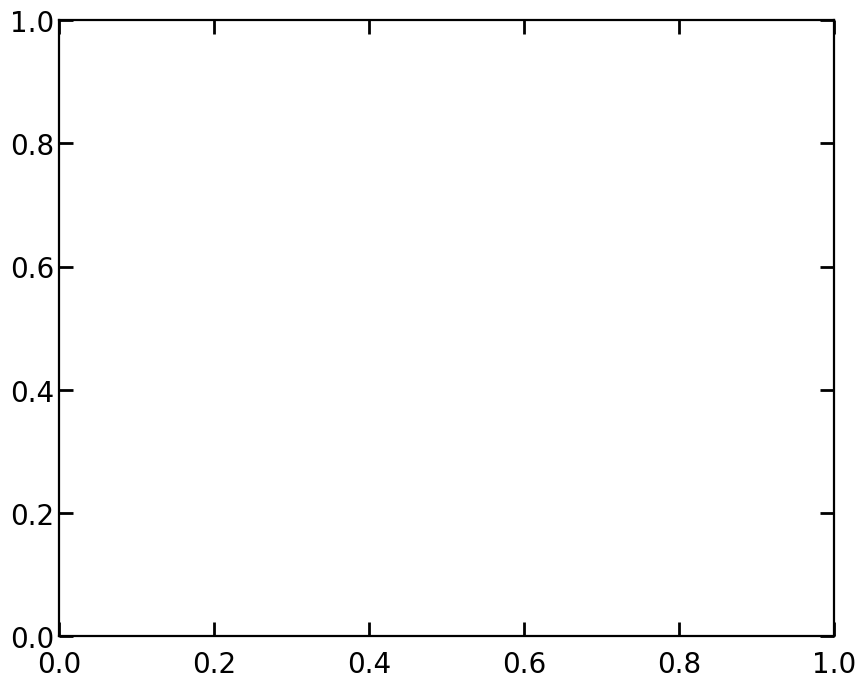

In [165]:
fig, ax = plt.subplots()
i=0
id=1
legend = []
for Rep in Replist:
    ax.plot(data_Rep_constant_24h[Rep].time[id]-data_Rep_constant_24h[Rep].time[id,0],data_Rep_constant_24h[Rep].uf[id],marker_array[i],color=color_array[i])   
    legend.append('$\\mathrm{Re_p} =$' +  f'{Rep}')
    i+=1

ax.legend(legend)

[nan nan nan ... nan nan nan]
<xarray.Dataset> Size: 5MB
Dimensions:     (trajectory: 624, obs: 300)
Coordinates:
  * obs         (obs) int32 1kB 0 1 2 3 4 5 6 7 ... 293 294 295 296 297 298 299
  * trajectory  (trajectory) int64 5kB 5 26 66 296 ... 88076 88123 88175 88253
Data variables:
    lat         (trajectory, obs) float32 749kB dask.array<chunksize=(624, 100), meta=np.ndarray>
    lon         (trajectory, obs) float32 749kB dask.array<chunksize=(624, 100), meta=np.ndarray>
    time        (trajectory, obs) float64 1MB dask.array<chunksize=(624, 100), meta=np.ndarray>
    uf          (trajectory, obs) float32 749kB dask.array<chunksize=(624, 100), meta=np.ndarray>
    vf          (trajectory, obs) float32 749kB dask.array<chunksize=(624, 100), meta=np.ndarray>
    Uslip       (trajectory, obs) float32 749kB dask.array<chunksize=(624, 100), meta=np.ndarray>
Attributes: (12/15)
    Conventions:            CF-1.6/CF-1.7
    coriolis:               True
    delta_x:                0.

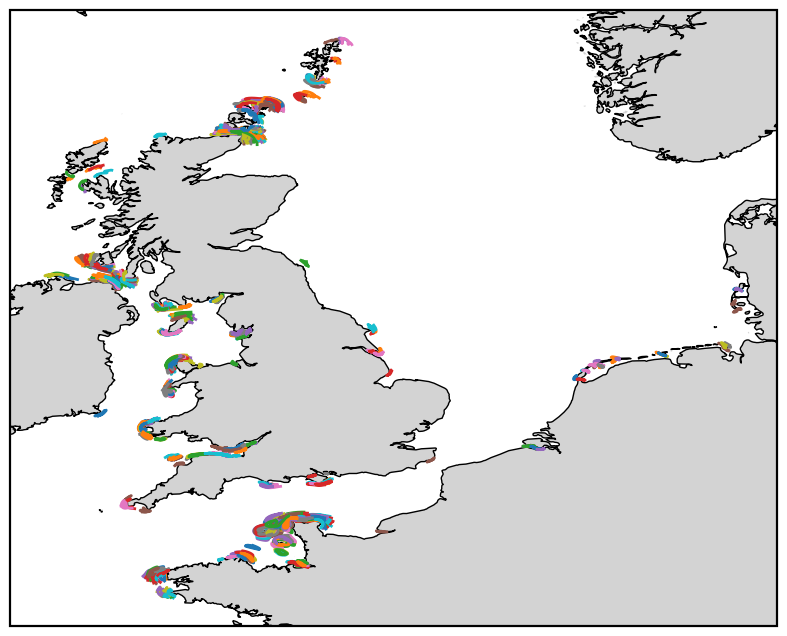

In [88]:
# check whether particle that shoots off is close to coast? 
# Rep = 300
# # ds =data_Rep_constant_24h[Rep].sel( data_Rep_constant_24h[Rep].Uslip > 1)
# ds= data_Rep_constant_24h[Rep].where(data_Rep_constant_24h[Rep].Uslip > 0.05)
# # fig, ax = plt.subplots()
# # plt.plot(data_Rep_constant_24h[Rep].Uslip)
# first_lon = ds.lon.bfill(dim='obs')[:,0]
# index = np.arange(0,nparticles,1)
# index = index[~np.isnan(first_lon.values)]
# print(first_lon.values)


# ds_select = data_Rep_constant_24h[Rep].isel(trajectory=index)
# print(ds_select)
# fig,ax=plt.subplots(figsize=(30,8),
#                      subplot_kw={'projection':ccrs.PlateCarree()})
# ax.coastlines()
# ax.add_feature(cart.feature.LAND, facecolor='lightgrey')

# ax.plot(ds_select.lon.T,ds_select.lat.T)

In [118]:
# make PDF and CDF for reynoldsnumber
mean_Rep_c_day={}
bins_Rep_c_day={}
pdfs_Rep_c_day={}
cdfs_Rep_c_day={}

def make_PDF2(x,nbins,norm,min=10000,max=-10000):
    
    if(min==10000):
        min=np.nanmin(x)
    if(max==-10000):
        max=np.nanmax(x)
    
    dx=(max-min)/nbins
    max+=dx
    min-=dx
    indices=((x-min)/dx).astype(int)
    print(x.shape)
    index = np.arange(0,indices.size,1)
    print( index[indices<0])
    pdf=np.zeros(nbins+3)
    np.add.at(pdf,indices,1)
    bins=np.arange(min,max+0.1*dx,dx)+0.5*dx
    if(norm == True):
        pdf/=x.size*dx
    return bins, pdf
for Rep in Replist:

    Re_particle = Re_slip(data_Rep_constant_24h[Rep].Uslip[:,1:],L, kinematic_viscosity_water)
    # fig, ax =plt.subplots()
    # ax.plot(Re_particle)
    # mean_Rep[particle_type] = Re_particle.mean(dim=None, skipna=True).values
    array = Re_particle.values.flatten()
    array=array[~np.isnan(Rep)]
    array = array[array<100000]
    array_wrong =array[array>100000]
    print(array_wrong.size)
    array = array[array<100000]
    
    mean_Rep_c_day[Rep]=np.mean(array)
    
    bins,pdf = make_PDF(array,nbins = 5000, norm = True)#,min=0,max=750000)
    dx=bins[1]-bins[0]
    cdf = np.cumsum(pdf*dx)
    bins_Rep_c_day[Rep]=bins
    pdfs_Rep_c_day[Rep]=pdf
    cdfs_Rep_c_day[Rep]=cdf

0
0
0
0


622.6939
429.89633
250.23242
62.690434


Text(0, 0.5, 'PDF')

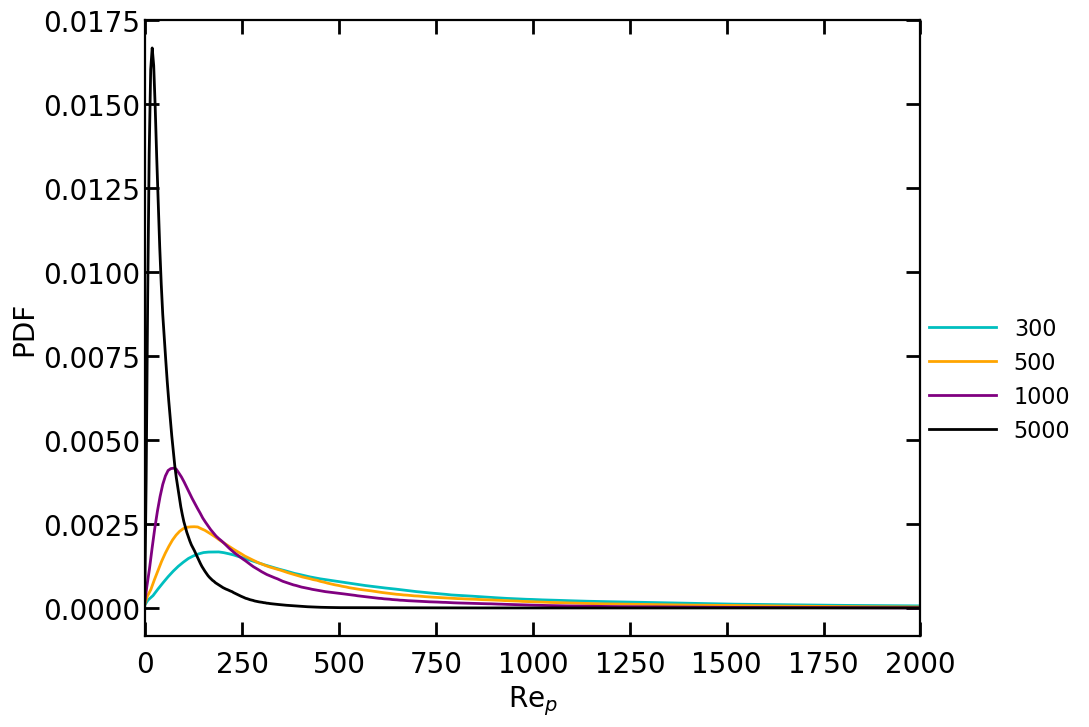

In [119]:
fig, ax = plt.subplots()
legend=[]
for Rep, color in zip(Replist, color_array):
    print(   mean_Rep_c_day[Rep])
    ax.plot(bins_Rep_c_day[Rep],pdfs_Rep_c_day[Rep],'-',color=color)


ax.legend(Replist,fontsize=16,loc=(1,0.3))
# for particle_type,color in zip(particle_types,color_array):
#     ax.axvline(mean_Rep[particle_type],color=color,zorder=-5)
ax.set_xlim(0,2000)
ax.set_xlabel('Re$_p$')
ax.set_ylabel('PDF')

622.6939
429.89633
250.23242
62.690434


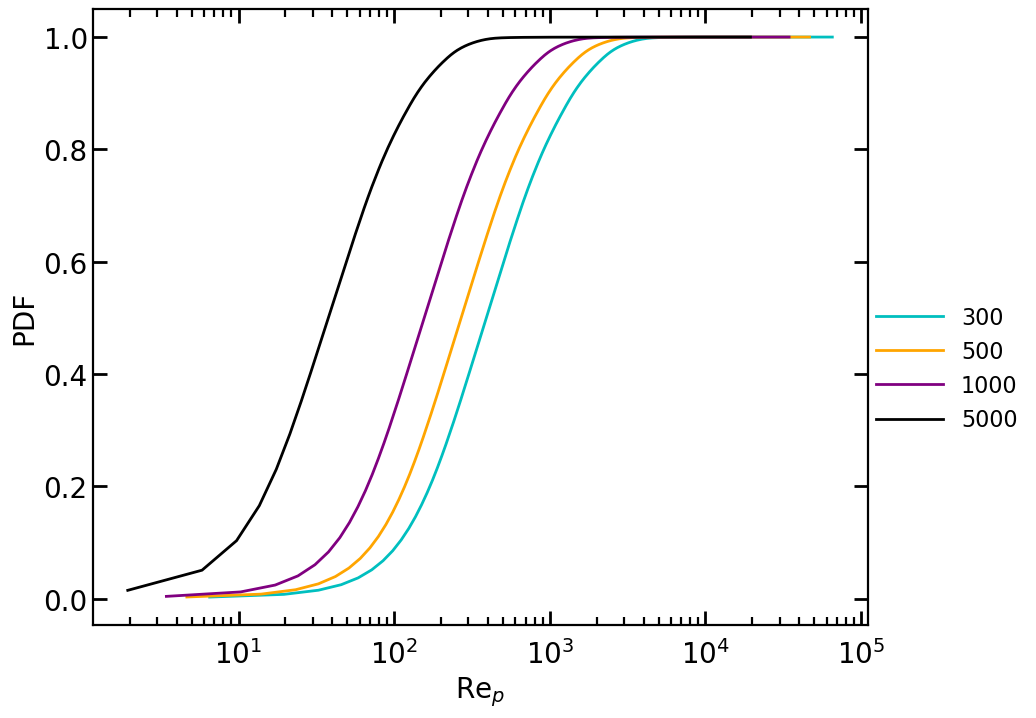

In [128]:
fig, ax = plt.subplots()
legend=[]
for Rep, color in zip(Replist, color_array):
    print(   mean_Rep_c_day[Rep])
    ax.plot(bins_Rep_c_day[Rep][1:],cdfs_Rep_c_day[Rep][1:],'-',color=color)


ax.legend(Replist,fontsize=16,loc=(1,0.3))
# for Rep,color in zip(Replist,color_array):
#     ax.axvline(mean_Rep_c_day[Rep],color=color,zorder=-5)
# ax.set_xlim(0,3000)
ax.set_xlabel('Re$_p$')
ax.set_ylabel('PDF')

ax.set_xscale('log')

In [162]:
def factor_drag(Rep):
    c_Rep = 1 + Rep / (4. * (1 +  np.sqrt(Rep))) + Rep / 60.
    return c_Rep

print(factor_drag(0))
print(factor_drag(300))

print(factor_drag(500))
print(factor_drag(1000))
print(factor_drag(5000))


1.0
10.093772928684475
14.684205020457055
25.330024174595543
101.76448909414918


In [181]:


Replist = np.array([400,450,500])


file_base = ('/storage/shared/oceanparcels/output_data/'
             'data_Meike/MR_advection/NWES/{particle_type}/'
            '{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                 '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_B{B:04d}_tau{tau:04d}_{land_handling}_cor_{cor_on}_Rep_{Rep:04d}_slip_velocity.zarr')
#settings
runtime =  timedelta(days=1)# timedelta(days=10)
loc = 'NWES'
B = 0.68
tau = 2759.97
coriolis = True
land_handling = 'anti_beaching'
starttime = datetime(2023, 9, 2, 0, 0, 0, 0)
endtime = starttime + runtime
particle_type = 'inertial_SM_Rep_constant'

chunck_time = 100
nparticles = 88347
data_SM_Rep_constant_24h = {}
for Rep in Replist: 
    file = file_base.format(loc=loc,
                           particle_type = particle_type,
                                                            y_s=starttime.year,
                                                            m_s=starttime.month,
                                                            d_s=starttime.day,
                                                            y_e=endtime.year,
                                                            m_e=endtime.month,
                                                            d_e=endtime.day,
                                                            B = int(B * 1000), 
                                                            tau = int(tau ),
                                                            land_handling = land_handling, 
                                                            cor_on = coriolis,
                                                            Rep = Rep )
    ds = xr.open_dataset(file,
                                    engine='zarr',
                                    chunks={'trajectory':nparticles, 'obs':chunck_time},
                                    drop_variables=['B','tau','z'],
                                    decode_times=False) #,decode_cf=False)
    Uslip = np.sqrt(ds.uf**2 + ds.vf**2) 
    ds = ds.assign(Uslip = Uslip)
    data_SM_Rep_constant_24h[Rep]=ds

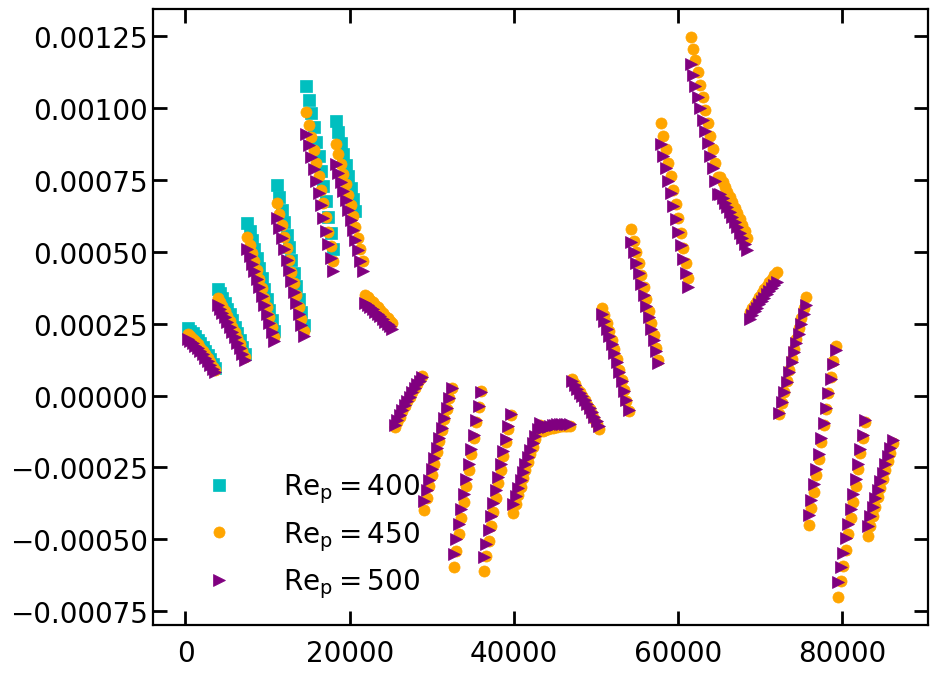

In [180]:
fig, ax = plt.subplots()
i=0
id=0
legend = []
for Rep in Replist:
    ax.plot(data_SM_Rep_constant_24h[Rep].time[id,1:]-data_SM_Rep_constant_24h[Rep].time[id,0],data_SM_Rep_constant_24h[Rep].uf[id,1:],marker_array[i],color=color_array[i])   
    legend.append('$\\mathrm{Re_p} =$' +  f'{Rep}')
    i+=1

ax.legend(legend)

In [182]:
data_SM_Rep_constant_24h[500].attrs

{'Conventions': 'CF-1.6/CF-1.7',
 'coriolis': True,
 'delta_x': '0.013889312744140625',
 'delta_y': '0.013889312744140625',
 'dt': '300.0',
 'feature_type': 'trajectory',
 'land_handling': 'anti_beaching',
 'ncei_template_version': 'NCEI_NetCDF_Trajectory_Template_v2.0',
 'nparticles': 88347,
 'parcels_kernels': 'InertialParticle2Dtoo_close_to_edgedisplacemeasure_slip_velocity_SMMRSMAdvectionRK4_2D_drag_REp_constantset_displacementremove_at_bounds',
 'parcels_mesh': 'spherical',
 'parcels_version': '3.0.2',
 'particle_type': 'inertial_SM_Rep_constant',
 'runtime': '86400.0',
 'write_dt': '300.0'}

In [183]:
# make PDF and CDF for reynoldsnumber
mean_SM_Rep_c_day={}
bins_SM_Rep_c_day={}
pdfs_SM_Rep_c_day={}
cdfs_SM_Rep_c_day={}

def make_PDF2(x,nbins,norm,min=10000,max=-10000):
    
    if(min==10000):
        min=np.nanmin(x)
    if(max==-10000):
        max=np.nanmax(x)
    
    dx=(max-min)/nbins
    max+=dx
    min-=dx
    indices=((x-min)/dx).astype(int)
    print(x.shape)
    index = np.arange(0,indices.size,1)
    print( index[indices<0])
    pdf=np.zeros(nbins+3)
    np.add.at(pdf,indices,1)
    bins=np.arange(min,max+0.1*dx,dx)+0.5*dx
    if(norm == True):
        pdf/=x.size*dx
    return bins, pdf
for Rep in Replist:

    Re_particle = Re_slip(data_SM_Rep_constant_24h[Rep].Uslip[:,2:],L, kinematic_viscosity_water)
    # fig, ax =plt.subplots()
    # ax.plot(Re_particle)
    # mean_Rep[particle_type] = Re_particle.mean(dim=None, skipna=True).values
    array = Re_particle.values.flatten()
    array=array[~np.isnan(Rep)]
    array = array[array<100000]
    array_wrong =array[array>100000]
    print(array_wrong.size)
    array = array[array<100000]
    
    mean_SM_Rep_c_day[Rep]=np.mean(array)
    
    bins,pdf = make_PDF(array,nbins = 5000, norm = True)#,min=0,max=750000)
    dx=bins[1]-bins[0]
    cdf = np.cumsum(pdf*dx)
    bins_SM_Rep_c_day[Rep]=bins
    pdfs_SM_Rep_c_day[Rep]=pdf
    cdfs_SM_Rep_c_day[Rep]=cdf

0
0
0


505.59714
462.87842
427.57294


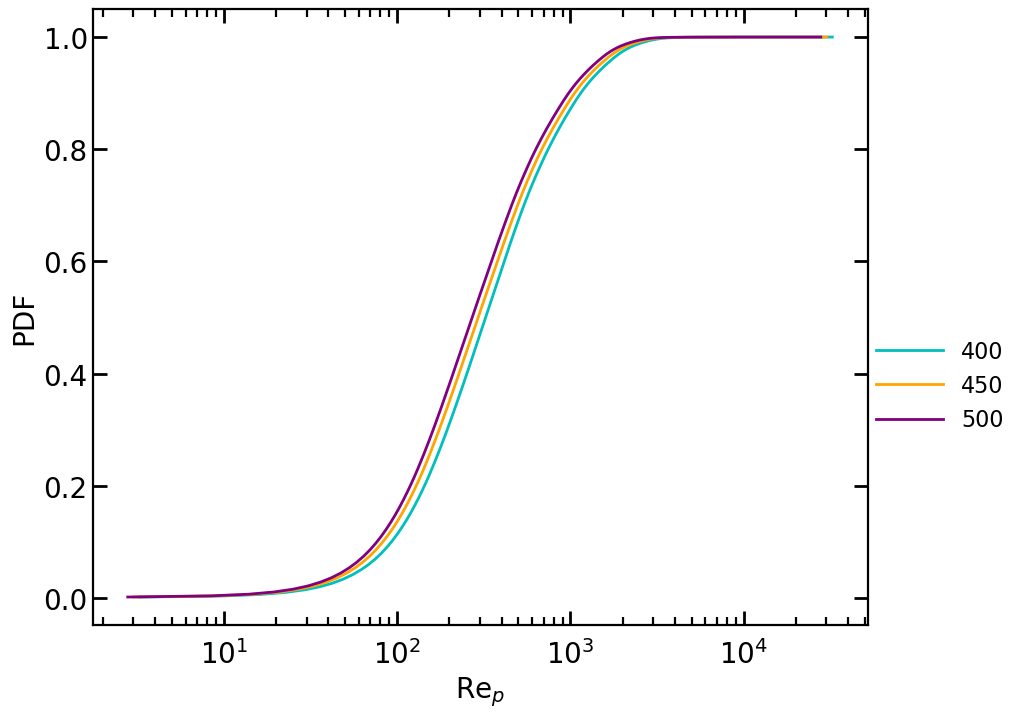

In [184]:
fig, ax = plt.subplots()
legend=[]
for Rep, color in zip(Replist, color_array):
    print(   mean_SM_Rep_c_day[Rep])
    ax.plot(bins_SM_Rep_c_day[Rep][1:],cdfs_SM_Rep_c_day[Rep][1:],'-',color=color)


ax.legend(Replist,fontsize=16,loc=(1,0.3))
# for Rep,color in zip(Replist,color_array):
#     ax.axvline(mean_Rep_c_day[Rep],color=color,zorder=-5)
# ax.set_xlim(0,3000)
ax.set_xlabel('Re$_p$')
ax.set_ylabel('PDF')

ax.set_xscale('log')
# REp = 450 seems very close (as in Rep what you use is what you get out)